# Simple network to minimize CRPS


The EMOS analog is a simple network like this:

![title](EMOS_network.png)

In this notebook we will build this simple network in theano and use the CRPS as a cost function. 

In [1]:
# First, let's import the libraries we need
import theano
import theano.tensor as T
import numpy as np

# Let's make this notebook reproducible by defining the random seed
np.random.RandomState(42)   # I don't even like the hitchhiker...

I followed this tutorial to figure out the theano basics: http://www.marekrei.com/blog/theano-tutorial/

We will now attempt to build a simplle class for our model following: https://github.com/marekrei/theano-tutorial/blob/master/classifier.py

So the first step is to create a class and initialize the network architecture. theano allocates a graph. This means that we first plot out the computations which will be done in the future. 

In [2]:
class EMOS_Network(object):
    def __init__(self):
        """
        This function is called once an object of this class is created.
        """
        # Before we start with the network, let's define
        # the learning rate as an input so we can vary it
        lr = T.fscalar('lr')
        
        # First let's define the input to the network
        # This is the ensemble mean (meanx), 
        # the ensemble stadnard deviation (stdx) and
        # the corresponding observation (target)
        # In theano we use tensors to describe these variables.
        # T.fvector allocates a float32 1D vector
        meanx = T.fvector('meanx')   # The name helps with debugging
        stdx = T.fvector('stdx')
        target = T.fvector('target')
        
        # Next we allocate the weights (a, b, c, d) as shared
        # variables and initialize some value for them.
        # For now we will just draw a random variable from N(0, 1)
        a = theano.shared(np.random.randn(), 'a')
        b = theano.shared(np.random.randn(), 'b')
        c = theano.shared(np.random.randn(), 'c')
        d = theano.shared(np.random.randn(), 'd')
        
        # Now that we have the input and the weights, 
        # we can set up the network.
        mu = a + meanx * b
        sigma = c + stdx * d
        
        # Now comes the cost function.
        # To stop sigma from becoming negative we first have to 
        # convert it the the variance and then take the square
        # root again. (I learned from experience...)
        # This part of the code is inspired by Kai Polsterer's code!
        var = T.sqr(sigma)
        # The following three variables are just for convenience
        loc = (target - mu) / T.sqrt(var)
        phi = 1.0 / np.sqrt(2.0 * np.pi) * T.exp(-T.square(loc) / 2.0)
        Phi = 0.5 * (1.0 + T.erf(loc / np.sqrt(2.0)))
        # First we will compute the crps for each input/target pair
        crps =  T.sqrt(var) * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))
        # Then we take the mean. The cost is now a scalar
        mean_crps = T.mean(crps)
        
        # Now compute the gradients of the cost function 
        # with respect to the four weights/parameters
        params = [a, b, c, d]   # Let's put them in a list for convenience
        gradients = theano.tensor.grad(mean_crps, params)
        
        # For gradient descent we now need to subtract the gradients
        # from our parameters to minimize the cost function
        # In theano we want to define a list of tuples containing
        # the old parameter and the updated parameter.
        updates = [(p, p - lr * g) for p, g in zip(params, gradients)]
        
        # So far no actual computations have been done. Now we will
        # define a Theano function, which takes input, does some 
        # calculations and returns some output. In our case, we use 
        # meanx, stdx and the target as an input plus the required 
        # learning rate and return the mean_crps
        # as an output. Then we tell the function to apply the update
        # every time it is called. This is the training
        self.train = theano.function([meanx, stdx, target, lr], 
                                     mean_crps, updates=updates)
        # Furthermore, we define a method for simply making a prediction
        # and returning the predicted values of mu and sigma
        # along with the mean_crps without updating the parameters
        self.predict = theano.function([meanx, stdx, target],
                                       [mu, sigma, mean_crps])

In [3]:
# Let's define some input arrays
nb_data = 100  # Number of data
# It is important that the input has the same type (float32) as the Theano tensors
in_meanx = np.asarray(np.random.randn(nb_data) + 3, dtype='float32')   # Random with mean 3 and std 1
in_stdx = np.asarray(2 * np.random.randn(nb_data) + 1, dtype='float32')
in_target = np.asarray(1.5 * np.random.randn(nb_data) + 2, dtype='float32')

In [4]:
# Let's create a perfect training set, where we should get perfect results
in_meanx = np.ones(nb_data, dtype='float32') * 3
in_stdx = np.ones(nb_data, dtype='float32') * 3
in_target = np.ones(nb_data, dtype='float32') * 2

Now we have set up our model and created some simple test data. Let's now initialize the network and train it!

In [5]:
# Initialize the network
model = EMOS_Network()

In [6]:
# Let's run over the data a few times and print out the crps every few steps
# Note that this is simply gradient descent, not stochastic, since
# we are giving the algorithm all the data for each update/
lr = np.asarray(0.001, dtype='float32')
for i in range(500):
    cost = model.train(in_meanx, in_stdx, in_target, lr)
    if i%10 == 0: print('Step %i; mean_crps = %.3f' % (i, cost))

Step 0; mean_crps = 2.790
Step 10; mean_crps = 2.722
Step 20; mean_crps = 2.656
Step 30; mean_crps = 2.592
Step 40; mean_crps = 2.531
Step 50; mean_crps = 2.472
Step 60; mean_crps = 2.415
Step 70; mean_crps = 2.359
Step 80; mean_crps = 2.306
Step 90; mean_crps = 2.254
Step 100; mean_crps = 2.204
Step 110; mean_crps = 2.156
Step 120; mean_crps = 2.109
Step 130; mean_crps = 2.064
Step 140; mean_crps = 2.020
Step 150; mean_crps = 1.978
Step 160; mean_crps = 1.937
Step 170; mean_crps = 1.897
Step 180; mean_crps = 1.859
Step 190; mean_crps = 1.822
Step 200; mean_crps = 1.786
Step 210; mean_crps = 1.751
Step 220; mean_crps = 1.717
Step 230; mean_crps = 1.684
Step 240; mean_crps = 1.653
Step 250; mean_crps = 1.622
Step 260; mean_crps = 1.592
Step 270; mean_crps = 1.563
Step 280; mean_crps = 1.534
Step 290; mean_crps = 1.507
Step 300; mean_crps = 1.480
Step 310; mean_crps = 1.455
Step 320; mean_crps = 1.429
Step 330; mean_crps = 1.405
Step 340; mean_crps = 1.381
Step 350; mean_crps = 1.358
Ste

In [7]:
preds = model.predict(in_meanx, in_stdx, in_target)

In [8]:
preds[0][:5]

array([ 0.41526058,  0.41526058,  0.41526058,  0.41526058,  0.41526058])

Good so far, we are able to reduce the CRPS and also get the correct predictions where possible. So now we can actually start thinking about real data!

Now let's load some real data.

In [9]:
# Copy this from the python_data_handling notebook. 
# Eventually this function will go in a separate file
from netCDF4 import Dataset
# Define directory where interpolated files are stored.
# DATA_DIR = '/project/meteo/w2w/C7/ppnn_data/'   # At LMU
DATA_DIR = '/Users/stephanrasp/repositories/ppnn/data/'  # Mac
# Define file name
fn = 'data_interpolated.nc'

In [10]:
rg = Dataset(DATA_DIR + 'data_interpolated.nc')

In [11]:
from netCDF4 import num2date
def get_data_slice(rg, month, utc=0):
    # Get array of datetime objects
    dates = num2date(rg.variables['time'][:],
                     units='seconds since 1970-01-01 00:00 UTC')
    # Extract months and hours
    months = np.array([d.month for d in list(dates)])
    hours = np.array([d.hour for d in list(dates)])
    
    # for now I need to include the Kelvin fix
    tfc = rg.variables['t2m_fc'][:]
    idx = np.where(np.mean(tfc, axis=(1, 2)) > 100)[0][0]
    tfc[idx:] = tfc[idx:] - 273.15
    
    # Extract the requested data
    tobs = rg.variables['t2m_obs'][(months == 1) & (hours == 0)]
    tfc = tfc[(months == 1) & (hours == 0)]
    return tobs, tfc

In [12]:
# Let's load the data for all of Jan for 00UTC init
tobs, tfc = get_data_slice(rg, 1, 0)

In [13]:
# Now we have to compute the mean and std for the ensemble
tfc_mean = np.mean(tfc, axis=1, dtype='float32')
tfc_std = np.std(tfc, axis=1, ddof=1, dtype='float32')

In [14]:
tfc_mean.shape

(310, 537)

In [15]:
tobs.shape

(310, 537)

In [17]:
# Flatten to 1D
tobs = np.ravel(np.asarray(tobs, dtype='float32'))
tfc_mean = np.ravel(tfc_mean)
tfc_std = np.ravel(tfc_std)

In [18]:
tobs.shape

(166470,)

In [20]:
np.isnan(tobs).sum()

14361

In [21]:
# Filter out nans
mask = np.isfinite(tobs)
tobs = tobs[mask]
tfc_mean = tfc_mean[mask]
tfc_std = tfc_std[mask]

Now we have the 1D arrays we need. Time to feed them to the learning network and learn.

In [36]:
# Initialize the network
model = EMOS_Network()

In [25]:
# Let's first check what our CRPS is without training
from scipy.stats import norm
def crps_normal(mu, sigma, y):
    loc = (y - mu) / sigma
    crps = sigma * (loc * (2 * norm.cdf(loc) - 1) + 
                    2 * norm.pdf(loc) - 1. / np.sqrt(np.pi))
    return crps

In [26]:
crps_normal(tfc_mean, tfc_std, tobs).mean()

1.35477760093263

So let's try training.
1. Gradient descent with all data and a learning rate of 0.1. Still learning after 500 steps. So after around 2000 steps we get a CRPS of around 1.113 which is lower than the EMOS global for Jan, but of course this is not a fair comparison.
2. Can we use a much higher learning rate with standard gradient descent? Try 0.5. Doesn't seem like it is working very well. Yes, 0.1 is much better.

In [29]:
# Were still masked arrays
tfc_mean = np.asarray(tfc_mean, dtype='float32')
tfc_std = np.asarray(tfc_std, dtype='float32')

In [37]:
# Let's train. Try gradient descent with all data at once
lr = np.asarray(0.1, dtype='float32')
for i in range(1000):
    cost = model.train(tfc_mean, tfc_std, tobs, lr)
    if i%100 == 0: print('Step %i; mean_crps = %.3f' % (i, cost))

Step 0; mean_crps = 2.967
Step 100; mean_crps = 1.117
Step 200; mean_crps = 1.115
Step 300; mean_crps = 1.115
Step 400; mean_crps = 1.114
Step 500; mean_crps = 1.114
Step 600; mean_crps = 1.114
Step 700; mean_crps = 1.114
Step 800; mean_crps = 1.114
Step 900; mean_crps = 1.114


In [38]:
# So the next step would be to update the data handling function to return the 
# data from the last 25 days
rg.variables['t2m_obs']

<class 'netCDF4._netCDF4.Variable'>
float32 t2m_obs(time, station)
    units: deg_C
    _FillValue: nan
    long_name: t2m station observation
unlimited dimensions: 
current shape = (7306, 537)
filling on

In [41]:
def get_rolling_slice(rg, date_idx, window_size=25, utc=0):
    """
    Return the forecast and observation data from the 
    previous *window_size* days. So if date_idx=10 and 
    window_size=3, it would get the data for indices 7, 8, 9.
    """
    # Get array of datetime objects
    dates = num2date(rg.variables['time'][:],
                     units='seconds since 1970-01-01 00:00 UTC')
    # Extract months and hours
    months = np.array([d.month for d in list(dates)])
    hours = np.array([d.hour for d in list(dates)])
    
    # for now I need to include the Kelvin fix
    tfc = rg.variables['t2m_fc'][:]
    idx = np.where(np.mean(tfc, axis=(1, 2)) > 100)[0][0]
    tfc[idx:] = tfc[idx:] - 273.15
    
    # Extract the requested data
    tobs = rg.variables['t2m_obs'][(hours == utc)]
    tfc = tfc[(hours == utc)]
    
    # Get the correct indices
    idx_start = date_idx - window_size
    idx_stop = date_idx
    
    # Get the slice for the indices
    tobs = tobs[idx_start:idx_stop]
    tfc = tfc[idx_start:idx_stop]
    
    return tobs, tfc

In [42]:
tobs_roll, tfc_roll = get_rolling_slice(rg, 25)

In [43]:
tfc_roll.shape

(25, 50, 537)

In [72]:
# Write a function compute means and std and flatten
def prep_data(tobs, tfc):
    ax = 0 if tobs.ndim == 1 else 1
    # Compute mean and std and convert to float32
    tfc_mean = np.mean(np.asarray(tfc, dtype='float32'), axis=ax)
    tfc_std = np.std(np.asarray(tfc, dtype='float32'), axis=ax, ddof=1)
    tobs = np.asarray(tobs, dtype='float32')
    
    # Flatten
    tobs = np.ravel(tobs)
    tfc_mean = np.ravel(tfc_mean)
    tfc_std = np.ravel(tfc_std)
    
    # Remove NaNs
    mask = np.isfinite(tobs)
    tobs = tobs[mask]
    tfc_mean = tfc_mean[mask]
    tfc_std = tfc_std[mask]
    
    return tobs, tfc_mean, tfc_std

In [47]:
tobs_roll, tfc_mean_roll, tfc_std_roll = prep_data(tobs_roll, tfc_roll)

In [48]:
tfc_mean_roll.shape

(11308,)

In [54]:
# Now let's train again.
model = EMOS_Network()

In [56]:
lr = np.asarray(0.1, dtype='float32')
for i in range(100):
    cost = model.train(tfc_mean_roll, tfc_std_roll, tobs_roll, lr)
    if i%10 == 0: print('Step %i; mean_crps = %.3f' % (i, cost))

Step 0; mean_crps = 1.047
Step 10; mean_crps = 1.046
Step 20; mean_crps = 1.045
Step 30; mean_crps = 1.044
Step 40; mean_crps = 1.044
Step 50; mean_crps = 1.044
Step 60; mean_crps = 1.043
Step 70; mean_crps = 1.043
Step 80; mean_crps = 1.043
Step 90; mean_crps = 1.043


So it seems to take max 200 steps to find the minimum. Time to actually loop over all the dates and compute the actual score!

In [58]:
# Let's actually modify the slicing function and feed it the full data.
# Because something took quite long earlier...
tobs_full = rg.variables['t2m_obs'][:]
tfc_full = rg.variables['t2m_fc'][:]
dates = num2date(rg.variables['time'][:],
                     units='seconds since 1970-01-01 00:00 UTC')

In [59]:
months = np.array([d.month for d in list(dates)])
hours = np.array([d.hour for d in list(dates)])

In [60]:
idx = np.where(np.mean(tfc_full, axis=(1, 2)) > 100)[0][0]
tfc_full[idx:] = tfc_full[idx:] - 273.15

In [61]:
# we can also alread get all the 00UTC data
tfc_full = tfc_full[hours == 0]
tobs_full = tobs_full[hours == 0]

In [124]:
def get_rolling_slice(tobs_full, tfc_full, date_idx, window_size=25, 
                      fclt=48):
    """
    Return the forecast and observation data from the 
    previous *window_size* days. So if date_idx=10 and 
    window_size=3, it would get the data for indices 7, 8, 9.
    Nope, also have to go back the forecast lead time.
    """
    fclt_didx = int(fclt / 24)
    
    # Get the correct indices
    idx_start = date_idx - window_size - fclt_didx
    idx_stop = date_idx - fclt_didx
    
    # Get the slice for the indices
    tobs_roll = tobs_full[idx_start:idx_stop]
    tfc_roll = tfc_full[idx_start:idx_stop]
    
    return tobs_roll, tfc_roll

In [120]:
dates_00 = dates[hours == 0]

In [121]:
dates_00.shape

(3653,)

In [125]:
# Let's do it fully for the first time step with predicting the current date
date_idx = 100
window_size = 50
tobs_roll, tfc_roll = get_rolling_slice(tobs_full, tfc_full, date_idx, 
                                        window_size)
tobs_date, tfc_date = (tobs_full[date_idx], tfc_full[date_idx])

In [126]:
tobs_date.shape

(537,)

In [127]:
tobs_roll, tfc_mean_roll, tfc_std_roll = prep_data(tobs_roll, tfc_roll)

In [128]:
tobs_date, tfc_mean_date, tfc_std_date = prep_data(tobs_date, tfc_date)

In [129]:
tobs_roll

array([ 5.69999981,  2.5999999 ,  3.0999999 , ...,  8.30000019,
        9.80000019,  6.30000019], dtype=float32)

In [130]:
model = EMOS_Network()

In [131]:
for i in range(200):
    cost = model.train(tfc_mean_roll, tfc_std_roll, tobs_roll, lr)
    if i%10 == 0: print('Step %i; mean_crps = %.3f' % (i, cost))

Step 0; mean_crps = 4.321
Step 10; mean_crps = 1.171
Step 20; mean_crps = 1.146
Step 30; mean_crps = 1.126
Step 40; mean_crps = 1.111
Step 50; mean_crps = 1.100
Step 60; mean_crps = 1.092
Step 70; mean_crps = 1.087
Step 80; mean_crps = 1.083
Step 90; mean_crps = 1.081
Step 100; mean_crps = 1.080
Step 110; mean_crps = 1.079
Step 120; mean_crps = 1.078
Step 130; mean_crps = 1.078
Step 140; mean_crps = 1.077
Step 150; mean_crps = 1.077
Step 160; mean_crps = 1.077
Step 170; mean_crps = 1.077
Step 180; mean_crps = 1.077
Step 190; mean_crps = 1.077


In [132]:
# Now make a prediction for the actual day
model.predict(tfc_mean_date, tfc_std_date, tobs_date)[2]

array(1.253791908507415)

In [83]:
dates_00[date_idx]

datetime.datetime(2007, 1, 28, 0, 0)

In [84]:
import datetime
np.where(dates_00 == datetime.datetime(2008, 1, 1, 0, 0))

(array([363]),)

In [133]:
np.where(dates_00 == datetime.datetime(2016, 12, 31, 0, 0))

(array([3650]),)

In [134]:
# Now let's actually loop
crps_train_list = []
crps_predict_list = []
lr = np.asarray(0.1, dtype='float32')
window_size = 50
for date_idx in range(363, 3651):   # Just try 50 days
    if date_idx % 50 == 0:
        print(dates_00[date_idx])
    tobs_roll, tfc_roll = get_rolling_slice(tobs_full, tfc_full, date_idx, 
                                            window_size)
    tobs_date, tfc_date = (tobs_full[date_idx], tfc_full[date_idx])
    tobs_roll, tfc_mean_roll, tfc_std_roll = prep_data(tobs_roll, tfc_roll)
    tobs_date, tfc_mean_date, tfc_std_date = prep_data(tobs_date, tfc_date)
    
    model = EMOS_Network()
    for i in range(200):
        cost = model.train(tfc_mean_roll, tfc_std_roll, tobs_roll, lr)
    crps_train_list.append(cost)
    
    crps_pred = model.predict(tfc_mean_date, tfc_std_date, tobs_date)[2]
    crps_predict_list.append(crps_pred)

2008-02-07 00:00:00
2008-03-28 00:00:00
2008-05-17 00:00:00
2008-07-06 00:00:00
2008-08-25 00:00:00
2008-10-14 00:00:00
2008-12-03 00:00:00
2009-01-22 00:00:00
2009-03-13 00:00:00
2009-05-02 00:00:00
2009-06-21 00:00:00
2009-08-10 00:00:00
2009-09-29 00:00:00
2009-11-18 00:00:00
2010-01-07 00:00:00
2010-02-26 00:00:00
2010-04-17 00:00:00
2010-06-06 00:00:00
2010-07-26 00:00:00
2010-09-14 00:00:00
2010-11-03 00:00:00
2010-12-23 00:00:00
2011-02-11 00:00:00
2011-04-02 00:00:00
2011-05-22 00:00:00
2011-07-11 00:00:00
2011-08-30 00:00:00
2011-10-19 00:00:00
2011-12-08 00:00:00
2012-01-27 00:00:00
2012-03-17 00:00:00
2012-05-06 00:00:00
2012-06-25 00:00:00
2012-08-14 00:00:00
2012-10-03 00:00:00
2012-11-22 00:00:00
2013-01-11 00:00:00
2013-03-02 00:00:00
2013-04-21 00:00:00
2013-06-10 00:00:00
2013-07-30 00:00:00
2013-09-18 00:00:00
2013-11-07 00:00:00
2013-12-27 00:00:00
2014-02-15 00:00:00
2014-04-06 00:00:00
2014-05-26 00:00:00
2014-07-15 00:00:00
2014-09-03 00:00:00
2014-10-23 00:00:00


In [135]:
# Save the data. Its past midingt and I can't be bothered to save them anywhere useful...
np.save('./EMOS_network_crps_train.npy', crps_train_list)
np.save('./EMOS_network_crps_predict.npy', crps_predict_list)

In [136]:
%matplotlib inline
import matplotlib.pyplot as plt

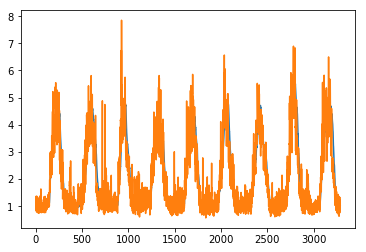

In [137]:
plt.plot(crps_train_list)
plt.plot(crps_predict_list)
plt.show()

Erm, well something is not right here